In [1]:
import awkward as ak
import h5py
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import os
import yaml
from helpers import load_dataset, stack, get_Z_candidates

mplhep.style.use("CMS")

In [2]:
datasets = {}
for n, file in enumerate(os.listdir("skimmed_datasets_v2")):
    print(f"Working on {file} ({n + 1}/8)")
    h5file = h5py.File(os.path.join("skimmed_datasets_v2", file), "r")
    datasets.update({file[:-3]: load_dataset(h5file)})
print("Finished!")

Working on ZZTo4e.h5 (1/8)
Working on ZZTo4mu.h5 (2/8)
Working on Run2012B_DoubleMuParked.h5 (3/8)
Working on SMHiggsToZZTo4L.h5 (4/8)
Working on Run2012C_DoubleMuParked.h5 (5/8)
Working on Run2012B_DoubleElectron.h5 (6/8)
Working on Run2012C_DoubleElectron.h5 (7/8)
Working on ZZTo2e2mu.h5 (8/8)
Finished!


In [13]:
def process_dataset(dataset: dict):
    muons = dataset["muons"]
    electrons = dataset["electrons"]
    
    ### Myonen
    passes_pt = muons["pt"] > 5
    passes_eta = abs(muons["eta"]) < 2.4
    muons = muons[passes_pt & passes_eta]

    ### Elektronen
    passes_pt = electrons["pt"] > 7
    passes_eta = abs(electrons["eta"]) < 2.5
    electrons = electrons[passes_pt & passes_eta]

    ### Nur gerade Anzahl an Elektronen und Myonen
    has_4mu = (ak.num(muons) == 4) & (ak.num(electrons) == 0)
    has_4e = (ak.num(muons) == 0) & (ak.num(electrons) == 4)
    has_2e2mu = (ak.num(muons) == 2) & (ak.num(electrons) == 2)
    
    passes_flav = has_4mu | has_4e | has_2e2mu
    electrons = electrons[passes_flav]
    muons = muons[passes_flav]

    ### Gesamtladung Null
    has_0Q_mu = ak.sum(muons["charge"], axis = 1) == 0
    has_0Q_e = ak.sum(electrons["charge"], axis = 1) == 0
    passes_Q = has_0Q_mu & has_0Q_e
    electrons = electrons[passes_Q]
    muons = muons[passes_Q]
    

    ### Falls 2e2m:, pt1 (2) > 20 (10) GeV
    muon_pt_sorted = ak.sort(muons["pt"], ascending = False)
    muon_pt_sorted = ak.fill_none(ak.pad_none(muon_pt_sorted, 2), -1)
    muon_mask = (muon_pt_sorted[:, 0] > 20) & (muon_pt_sorted[:, 1] > 10)
    electron_pt_sorted = ak.sort(electrons["pt"], ascending = False)
    electron_pt_sorted = ak.fill_none(ak.pad_none(electron_pt_sorted, 2), -1)
    electron_mask = (electron_pt_sorted[:, 0] > 20) & (electron_pt_sorted[:, 1] > 10)
    passes_pt_2e2mu = ak.where(ak.num(muons) == 2, muon_mask & electron_mask, ak.num(muons) != 2)

    electrons = electrons[passes_pt_2e2mu]
    muons = muons[passes_pt_2e2mu]


    ### Z Fenster
    mZ_1, mZ_2, dR1, dR2 = get_Z_candidates(muons, electrons)
    passes_Z1 = (mZ_1 > 40) & (mZ_1 < 120)
    passes_Z2 = (mZ_2 > 12) & (mZ_2 < 120)

    ### dR cut
    passes_dRcut = (dR1 > 0.02) & (dR2 > 0.02)
    
    passes_Zcuts = passes_Z1 & passes_Z2 & passes_dRcut
    electrons = electrons[passes_Zcuts]
    muons = muons[passes_Zcuts]
    
    leptons = ak.concatenate((muons, electrons), axis = 1)
    mass = ak.sum(leptons.to_xyzt(), axis = 1).mass
    
    return mass

In [9]:
def process_dataset(dataset: dict):
    muons = dataset["muons"]
    electrons = dataset["electrons"]

    leptons = ak.concatenate((muons, electrons), axis = 1)
    mass = ak.sum(leptons.to_xyzt(), axis = 1).mass

    return mass

In [14]:
masses = {}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")
    n_pre = len(dataset["muons"])
    m = process_dataset(dataset)
    n_post = len(m)
    print(f"   Events before processing: {n_pre}")
    print(f"   Events after processing: {n_post}")
    
    masses.update({name: process_dataset(dataset)})

Processing dataset ZZTo4e
   Events before processing: 96104
   Events after processing: 62138
Processing dataset ZZTo4mu
   Events before processing: 178229
   Events after processing: 101660
Processing dataset Run2012B_DoubleMuParked
   Events before processing: 405
   Events after processing: 69
Processing dataset SMHiggsToZZTo4L
   Events before processing: 39805
   Events after processing: 23185
Processing dataset Run2012C_DoubleMuParked
   Events before processing: 662
   Events after processing: 122
Processing dataset Run2012B_DoubleElectron
   Events before processing: 162
   Events after processing: 43
Processing dataset Run2012C_DoubleElectron
   Events before processing: 279
   Events after processing: 69
Processing dataset ZZTo2e2mu
   Events before processing: 116010
   Events after processing: 51249


In [15]:
def plot_m4l(
    m4l: dict, blinded =  True, syst = True
):

    ### Lade Skalierungsfaktoren
    with open("weights.yaml", "r") as wfile: weights = yaml.safe_load(wfile)

    ### Erstelle Histogramme (Start und Stop der Bins sind hier willkürlich)
    bins = np.linspace(70, 180, 36)
    bin_width = bins[1] - bins[0]
    hists = {
        name: np.histogram(m4l[name], bins)[0] * weights[name] for name in m4l.keys()
    }
    

    DY = hists["ZZTo4mu"] + hists["ZZTo4e"] + hists["ZZTo2e2mu"]
    S = hists["SMHiggsToZZTo4L"]
    stat_mc = np.sqrt(DY + S)
    stat_mc_down = DY + S - stat_mc
    stat_mc_up = DY + S + stat_mc

    data = (
        hists["Run2012B_DoubleMuParked"] + hists["Run2012C_DoubleMuParked"]
        + hists["Run2012B_DoubleElectron"] + hists["Run2012C_DoubleElectron"]
    )
    stat_data = np.sqrt(data)

    plt.figure(dpi = 60)
    mplhep.cms.text("Open Data")
    mplhep.cms.lumitext("$11.6$ $\\text{fb}^{-1}$")
    plt.stackplot(
        bins[:-1],
        list(hists["ZZTo4mu"] + hists["ZZTo4e"] + hists["ZZTo2e2mu"]),
        list(hists["SMHiggsToZZTo4L"]),
        labels = ["Drell-Yan", "$H \\rightarrow ZZ \\rightarrow 4\\ell$"],
        step = "post"
    )
    if blinded:
        plt.fill_between(
            bins[:-1], stat_mc_down, stat_mc_up, 
            step = "post", hatch = "///", alpha = 0.5, facecolor = "none", edgecolor = "black", linewidth = 0
        )
    else:
        plt.errorbar(
            bins[:-1] + bin_width / 2, data, yerr = stat_data, fmt = "o", color = "black"
        )
    plt.xlabel("$m_{4\\ell}$ [GeV]")
    plt.ylabel("Counts/bin")
    plt.xlim(70, 180)
    plt.ylim(bottom = 0)
    plt.legend()
    plt.show()

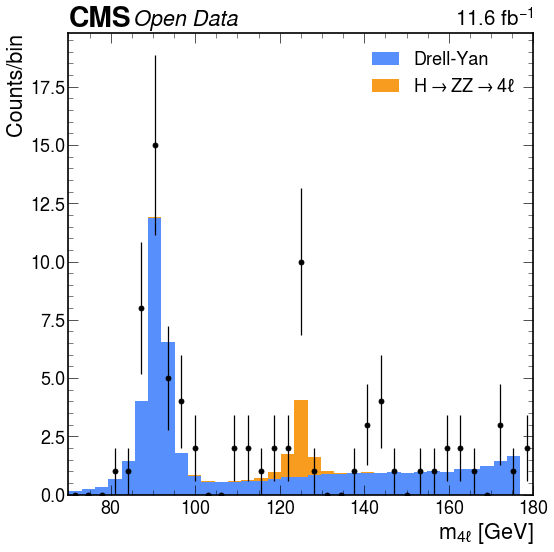

In [16]:
plot_m4l(masses, blinded = False)